# Session 2 - Introduction to Rasterio
In this tutorial, we will process raster data for multiple years of Ecuador. We will do the processing in chunks given potential large size of raster data. Also we will clean it, calculate zonal statistics for predefined polygons (from a shapefile that include Ecuador parishes), and combine the results into a single dataset.

# Table of Contents
- [1. Understanding Raster Data](#t1)
- [2. Data Source and Explanation](#t2)
- [3. Plotting maps](#t3)

<a id="t1"></a>  
### Understanding Raster Data

#### **What is Raster Data?**
Raster data represents geospatial information in a grid-like structure, where each cell (or pixel) has a value corresponding to a particular attribute, such as elevation, temperature, or land use. These values are usually continuous or discrete numerical data. Raster data is commonly used in remote sensing, environmental modeling, and geographic analysis because it efficiently handles large datasets and spatially continuous phenomena.

#### **What is the TIFF Format?**
The TIFF (Tagged Image File Format) is a widely used file format for storing raster data. It is particularly popular in geospatial applications when combined with metadata, forming a **GeoTIFF**. This metadata includes georeferencing information (e.g., projection, coordinates), allowing the file to be mapped accurately in geographic space. TIFF files support multiple bands (e.g., red, green, blue, and infrared for satellite images), making them versatile for remote sensing and analysis.

#### **What is Resolution in Raster Data?**
Resolution in raster data refers to the size of each cell in real-world units. For example, a raster with a 30-meter resolution means each pixel represents an area of 30 x 30 meters on the ground. Higher resolution (smaller cell size) provides more detailed spatial information but increases file size and computational demands. Resolution is critical in ensuring the suitability of data for specific analyses—coarser resolutions may miss fine details, while higher resolutions may capture unnecessary information for broader-scale studies.

#### **What are Shapefiles?**
Shapefiles (.shp) are a common vector data format used in Geographic Information Systems (GIS). Unlike raster data, vector data represents geographic features as points, lines, and polygons. Shapefiles are often used for data like administrative boundaries, road networks, and locations of interest. A shapefile actually consists of several files working together (e.g., .shp, .shx, .dbf) to store geometric shapes, spatial indexing, and attribute data.

#### **Key Differences Between Raster and Shapefiles**
| **Aspect**        | **Raster Data**                          | **Shapefiles (Vector Data)**            |
|--------------------|------------------------------------------|-----------------------------------------|
| **Structure**     | Grid of pixels (cells)                  | Points, lines, and polygons            |
| **Data Type**     | Continuous or categorical values        | Discrete features with attributes       |
| **File Format**   | TIFF, GeoTIFF, etc.                     | Shapefile (.shp, .shx, .dbf)           |
| **Use Cases**     | Elevation, satellite imagery, land use  | Boundaries, roads, administrative zones |
| **Resolution**    | Fixed resolution (cell size)            | No resolution—geometry determines precision |
| **File Size**     | Large for high resolution               | Smaller for similar geographic extent   |

#### **Summary**
Raster and vector data serve complementary purposes in geospatial analysis. Raster data is better for continuous phenomena like elevation or satellite imagery, while shapefiles excel at representing discrete features like administrative boundaries or road networks. Understanding their differences ensures effective usage in GIS projects.

#### **Step 1: Import Necessary Libraries**
First, import all the libraries required for data processing, handling geospatial data, and plotting.
These libraries will help us handle raster files, manipulate geospatial data, and calculate zonal statistics efficiently.

In [9]:
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

#### **Step 2: Define a Function to Process Raster Chunks**

We will define a function to clean raster chunks by replacing certain values with `NaN` or other specified values. This ensures invalid or unwanted data points are handled.


In [10]:
def process_chunk(data_chunk):
    # Replace values 0, 3, and 4 with np.nan (missing values)
    data_chunk = np.where(np.isin(data_chunk, [0, 3, 4]), np.nan, data_chunk)
    # Replace value 2 with 0
    return np.where(data_chunk == 2, 0, data_chunk)

<a id="t2"></a>
### Data Source and Explanation

The raster data used in this analysis comes from **MapBiomas**, a publicly accessible dataset providing high-resolution land use and land cover information. The data is organized at the **pixel level**, with each pixel representing a small area of land and containing a value indicating its type of use:

- **Natural Use (=1):** The pixel corresponds to land used for natural purposes, such as forests, grasslands, or wetlands.
- **Anthropic Use (=0):** The pixel corresponds to land used for human activities, such as agriculture, urbanization, or industrial development.

#### **Purpose of the Process**
The goal of the analysis is to summarize this pixel-level data to a larger geographic unit—**parishes** (administrative divisions). For each parish, we calculate the **mean value** of the pixels within its boundaries. Since the pixel values are binary (1 for natural, 0 for anthropic), the mean provides the **proportion of natural land use** within each parish. For example:

- A mean value of **0.75** in a parish indicates that **75% of the land** in that parish is classified as natural use.
- A mean value of **0.25** implies that **25% of the land** is natural use, and the remaining **75%** is anthropic.

This process effectively transforms granular pixel-level data into aggregated insights at the parish level, enabling comparisons and trends analysis across administrative boundaries.

#### **Step 3: Initialize a Container for Results**
We create an empty list to store the processed data for each year.

In [11]:
all_data = []

#### **Step 4: Loop Through Years and Process Raster Files**

For each year in the dataset:
1. Open the corresponding raster file.
2. Process the raster in manageable chunks.
3. Extract a subset of the data for analysis.
4. Adjust the spatial transform to align with the subset.

In [12]:
year = 1985
with rasterio.open(f"../02_data/MB-Ecuador-{year}.tif") as src:
    window_size = 1024
    full_transform = src.transform
    processed_data = np.empty((src.height, src.width), dtype='float32')

    # Process raster in chunks
    for ji, window in src.block_windows(1):
        data_chunk = src.read(1, window=window).astype('int16')
        processed_chunk = process_chunk(data_chunk)
        processed_data[window.toslices()] = processed_chunk

    # Slice raster data
    sliced_data = processed_data[:, 40000:]
    new_transform = src.window_transform(((0, src.height), (40000, src.width)))
    raster_crs = src.crs

#### **Step 5: Load and Reproject Polygon Data**

Load the shapefile containing polygons (e.g., administrative boundaries). Ensure its Coordinate Reference System (CRS) matches the raster's CRS.


In [13]:
polygons = gpd.read_file('../02_data/shapefiles/nivel-politico-4.shp')
current_crs = "EPSG:4326"

if polygons.crs is None:
    polygons = polygons.set_crs(current_crs)

polygons = polygons.to_crs(raster_crs)

#### **Step 6: Calculate Zonal Statistics**

Using the `zonal_stats` function, calculate the mean of the raster values within each polygon. Add these results to the polygon DataFrame.


In [14]:
zonal_stats_results = zonal_stats(
    polygons, sliced_data, affine=new_transform, nodata=np.nan, stats="mean")
polygons["zonal_mean"] = [x["mean"] for x in zonal_stats_results]
polygons["year"] = year
polygons["parroquia_num"] = polygons.index

#### **Step 7: Clean and Append Data**

Remove unnecessary columns, rename remaining ones, and append the processed data to the results list.

In [15]:
polygons.drop(columns=["TERRITORY_", "CATEGORY", "TYPE", "LEVEL_1", "geometry"], inplace=True)
polygons.rename(columns={"NAME": "PARROQUIA", "LEVEL_2": "PROVINCIA", "LEVEL_3": "CANTON"}, inplace=True)
all_data.append(polygons)

#### **Step 8: Combine and Save Results**

Once all years are processed, concatenate the results into a single DataFrame and save it as a CSV file.
**Output:** The processed data for all years is saved in the specified location.

In [16]:
final_df = pd.concat(all_data, ignore_index=True)
final_df.head()
#final_df.to_csv("../03_data/database/parroquias-zonal-mean_try.csv", index=False)

,FEATURE_ID,PARROQUIA,PROVINCIA,CANTON,NAME_PT_BR,zonal_mean,year,parroquia_num
0,247,ARENILLAS,EL ORO,ARENILLAS,ARENILLAS [ARENILLAS] [EL ORO] [Ecuador],0.366211,1985,0
1,248,CHACRAS,EL ORO,ARENILLAS,CHACRAS [ARENILLAS] [EL ORO] [Ecuador],0.816372,1985,1
2,249,PALMALES,EL ORO,ARENILLAS,PALMALES [ARENILLAS] [EL ORO] [Ecuador],0.364936,1985,2
3,250,CARCABÃN,EL ORO,ARENILLAS,CARCABÃN [ARENILLAS] [EL ORO] [Ecuador],0.647704,1985,3
4,251,PACCHA,EL ORO,ATAHUALPA,PACCHA [ATAHUALPA] [EL ORO] [Ecuador],0.320557,1985,4


#### This loop will create it for all years

In [17]:
# Loop over the years
for year in range(1985, 1987):

    print(f"Processing year {year}")

    # Open the raster file
    with rasterio.open(f"../02_data/MB-Ecuador-{year}.tif") as src:
        # Get the window size (chunk size) and other metadata
        window_size = 1024  # Define a reasonable chunk size

        # Get the transform for the whole raster
        full_transform = src.transform

        # Initialize an empty array for storing processed data slices
        processed_data = np.empty((src.height, src.width), dtype='float32')

        # Process the raster in chunks
        for ji, window in src.block_windows(1):
            # Read a chunk of the raster data
            data_chunk = src.read(1, window=window).astype('int16')

            # Process the chunk (replace 0, 3, 4 with np.nan, and 2 with 0)
            processed_chunk = process_chunk(data_chunk)

            # Place the processed chunk into the final array
            processed_data[window.toslices()] = processed_chunk

        # Slice the processed raster data
        sliced_data = processed_data[:, 40000:]

        # Adjust the transform for the sliced portion
        new_transform = src.window_transform(((0, src.height), (40000, src.width)))

        # Get the CRS of the raster
        raster_crs = src.crs

        # Load the shapefile with the borders
        polygons = gpd.read_file('../02_data/shapefiles/nivel-politico-4.shp')

        # Assuming you know the current CRS of the borders GeoDataFrame
        current_crs = "EPSG:4326"  # Replace with the actual CRS of your shapefile

        # Set the current CRS if not already set
        if polygons.crs is None:
            polygons = polygons.set_crs(current_crs)

        # Reproject the borders to match the raster CRS
        polygons = polygons.to_crs(raster_crs)

        # Calculate zonal statistics, excluding np.nan (from nodata and replaced values)
        zonal_stats_results = zonal_stats(polygons, sliced_data, affine=new_transform, nodata=np.nan, stats="mean")

        # Add the zonal statistics to the polygon dataframe
        polygons["zonal_mean"] = [x["mean"] for x in zonal_stats_results]

        polygons["year"] = year

        polygons['parroquia_num'] = polygons.index

        polygons.drop(columns=["TERRITORY_", "CATEGORY", "TYPE", "LEVEL_1", "geometry"], inplace=True)

        polygons.rename(columns={"NAME": "PARROQUIA", "LEVEL_2": "PROVINCIA", "LEVEL_3" : "CANTON"}, inplace=True)

        all_data.append(polygons)

        print(f"Year {year} processed")

# Concatenate all dataframes to creae¿te the final dataframe
final_df = pd.concat(all_data, ignore_index=True)
final_df
#final_df.to_csv("../03_data/database/parroquias-zonal-mean_try.csv", index=False)

#print("All data processed and saved at '../03_data/database/parroquias-zonal-mean_all.csv'")

Processing year 1985
Year 1985 processed
Processing year 1986
Year 1986 processed


,FEATURE_ID,PARROQUIA,PROVINCIA,CANTON,NAME_PT_BR,zonal_mean,year,parroquia_num
0,247,ARENILLAS,EL ORO,ARENILLAS,ARENILLAS [ARENILLAS] [EL ORO] [Ecuador],0.366211,1985,0
1,248,CHACRAS,EL ORO,ARENILLAS,CHACRAS [ARENILLAS] [EL ORO] [Ecuador],0.816372,1985,1
2,249,PALMALES,EL ORO,ARENILLAS,PALMALES [ARENILLAS] [EL ORO] [Ecuador],0.364936,1985,2
3,250,CARCABÃN,EL ORO,ARENILLAS,CARCABÃN [ARENILLAS] [EL ORO] [Ecuador],0.647704,1985,3
4,251,PACCHA,EL ORO,ATAHUALPA,PACCHA [ATAHUALPA] [EL ORO] [Ecuador],0.320557,1985,4
...,...,...,...,...,...,...,...,...
3121,1284,PUERTO LÃPEZ,MANABÃ,PUERTO LÃPEZ,PUERTO LÃPEZ [PUERTO LÃPEZ] [MANABÃ] [Ecuador],0.835828,1986,1037
3122,1285,PUERTO LÃPEZ,MANABÃ,PUERTO LÃPEZ,PUERTO LÃPEZ [PUERTO LÃPEZ] [MANABÃ] [Ecuador],0.959167,1986,1038
3123,1286,LA LIBERTAD,SANTA ELENA,LA LIBERTAD,LA LIBERTAD [LA LIBERTAD] [SANTA ELENA] [Ecuador],NaN,1986,1039
3124,1287,LA LIBERTAD,SANTA ELENA,LA LIBERTAD,LA LIBERTAD [LA LIBERTAD] [SANTA ELENA] [Ecuador],NaN,1986,1040


<a id="t3"></a>  
### Plotting maps

With the processed data, we can plot maps to visualize the distribution of natural land use across Ecuador's parishes. We will use the `geopandas` library to plot the country borders.

#### **Step 1: Define libraries and load files**

We create a color map to represent the proportion of natural land use in each parish. The color map ranges from red (0% natural) to green (100% natural), providing a visual gradient of land use types. We then load the processed data and the shapefile for Ecuador's parishes.

In [18]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import Transformer

In [19]:
cmap = mcolors.LinearSegmentedColormap.from_list("yellow_green",
["#494f14","#7b8422", "#b7b722", "yellow", "#ffffb2", "#eaffb2",
"#b2ffb2", "#73d973", "green", "darkgreen"], N=15)
norm = mcolors.Normalize(vmin=0, vmax=1)

borders = gpd.read_file('../02_data/shapefiles/nivel-politico-4.shp')
borders.drop(columns=["TERRITORY_", "CATEGORY", "TYPE", "LEVEL_1"], inplace=True)
borders.rename(columns={"NAME": "PARROQUIA", "LEVEL_2": "PROVINCIA", "LEVEL_3": "CANTON"}, inplace=True)

#### **Step 2: Plot the raster file**
We first plot the raster data, without plotting the shapefiles. This provides a visual representation of the land use distribution across Ecuador. Brighter locations represent a greater presence of human activities, i.e., anthrophic activity, which includes cities, mining, industries, agriculture, etc.

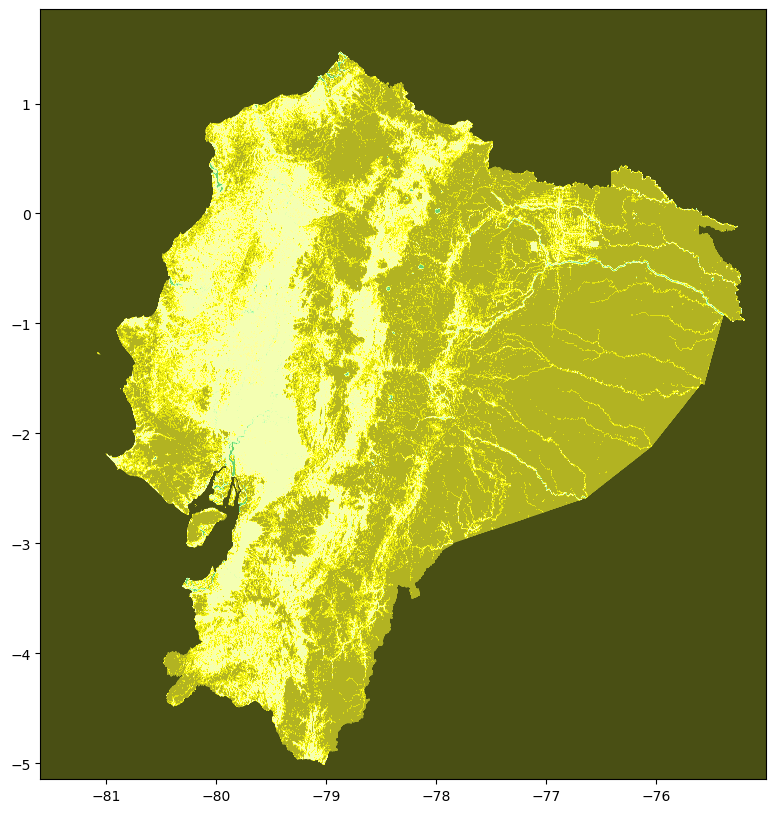

In [20]:
for year in range(1985, 1986):

    df = final_df[final_df['year'] == int(year)]
    preds_year = pd.merge(df, borders[['FEATURE_ID', 'PARROQUIA', 'PROVINCIA', 'CANTON', 'geometry']], on=['PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
    preds_year = gpd.GeoDataFrame(preds_year, geometry='geometry')

    with rasterio.open(f'../02_data/MB-Ecuador-{year}.tif') as src:

        # Slice the raster data to only include mainland Ecuador
        data = src.read(1)
        sliced_data = data[:, 40000:]
        new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
        raster_crs = src.crs
        
        fig, ax = plt.subplots(figsize=(10, 10))
        show(sliced_data, transform=new_transform, ax=ax, cmap=cmap) 




#### **Step 3: Plot the shapefile with the natural use per administrative unit**
We then overlay the parish boundaries to show the natural land use proportions within each administrative unit, which we calculated in the previous section in the column `zonal_mean`. We observe that the browner colors correspond to the parishes where there is greater anthropic use, while the greener colors correspond to a higher level of natural use.

Plotting year:  1985


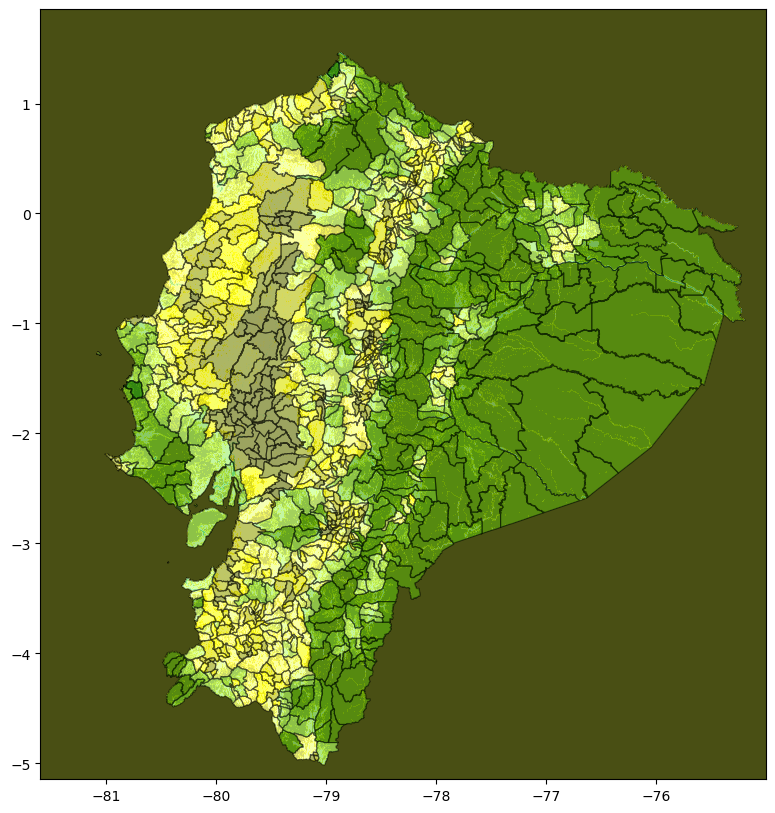

In [ ]:
for year in range(1985, 1986):

    df = final_df[final_df['year'] == int(year)]
    preds_year = pd.merge(df, borders[['FEATURE_ID', 'PARROQUIA', 'PROVINCIA', 'CANTON', 'geometry']], on=['PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
    preds_year = gpd.GeoDataFrame(preds_year, geometry='geometry')

    with rasterio.open(f'../02_data/MB-Ecuador-{year}.tif') as src:

        # Slice the raster data to only include mainland Ecuador
        data = src.read(1)
        sliced_data = data[:, 40000:]
        new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
        raster_crs = src.crs
        
        fig, ax = plt.subplots(figsize=(10, 10))
        show(sliced_data, transform=new_transform, ax=ax, cmap=cmap)

        # Plot the data with the specified color map
        preds_year.plot(column='zonal_mean', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='black', alpha=0.3)   

#### **Step 4: Add shapefiles with the delimiting borders**
Finally, we add the shapefiles with the delimiting borders of Ecuador to improve the visuals of the map.


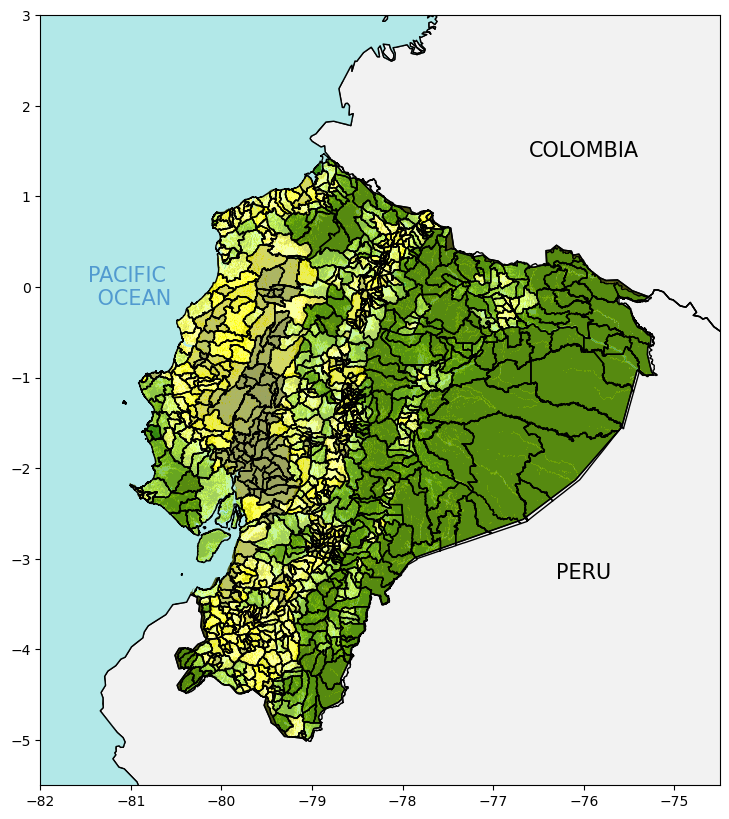

In [45]:
for year in range(1985, 1986):

    df = final_df[final_df['year'] == int(year)]
    preds_year = pd.merge(df, borders[['FEATURE_ID', 'PARROQUIA', 'PROVINCIA', 'CANTON', 'geometry']], on=['PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
    preds_year = gpd.GeoDataFrame(preds_year, geometry='geometry')

    with rasterio.open(f'../02_data/MB-Ecuador-{year}.tif') as src:

        # Slice the raster data to only include mainland Ecuador
        data = src.read(1)
        sliced_data = data[:, 40000:]
        new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
        raster_crs = src.crs
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the data with the specified color map
        preds_year.plot(column='zonal_mean', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='black', alpha=0.3)

        # Load and plot shapefiles (borders, ocean, and neighboring countries as before)
        ecuador_borders = gpd.read_file('../02_data/shapefiles/ecuador_borders.shp')
        ocean_borders = gpd.read_file('../02_data/shapefiles/ne_10m_ocean.shp')

        # Set CRS if needed and reproject to raster CRS as before
        ecuador_borders = ecuador_borders.set_crs("EPSG:4326") if ecuador_borders.crs is None else ecuador_borders
        ecuador_borders = ecuador_borders.to_crs(raster_crs)
        borders = borders.set_crs("EPSG:4326") if borders.crs is None else borders
        borders = borders.to_crs(raster_crs)
        ocean_borders = ocean_borders.set_crs("EPSG:4326") if ocean_borders.crs is None else ocean_borders
        ocean_borders = ocean_borders.to_crs(raster_crs)

        ecuador_borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
        ecuador_borders.plot(ax=ax, color='#f2f2f2', edgecolor='black', linewidth=1)
        borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
        ocean_borders.plot(ax=ax, color='#b2e8e8', alpha=1)

        ax.text(-76, -3.15, 'PERU', fontsize=15, color='black', ha='center', va='center')
        ax.text(-76, 1.5, 'COLOMBIA', fontsize=15, color='black', ha='center', va='center')
        ax.text(-81, 0, 'PACIFIC \n OCEAN', fontsize=15, color='#519ad0', ha='center', va='center')

        # Convert lat/lon bounding box to the raster CRS
        transformer = Transformer.from_crs("EPSG:4326", raster_crs)
        xmin, ymin = transformer.transform(-82, -5.5)  # Lower-left corner (lon_min, lat_min)
        xmax, ymax = transformer.transform(-74.5, 3)   # Upper-right corner (lon_max, lat_max)

        # Set the axis limits around Ecuador
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        show(sliced_data, transform=new_transform, ax=ax, cmap=cmap)

        plt.show()          


#### **Step 5: Customize your map plot**
You can customize the map plot by adjusting the color map, adding a legend, and setting a scalebar and a north arrow. These modifications enhance the readability and interpretability of the map, making it more informative for viewers.

In [21]:
from geo_northarrow import add_north_arrow
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

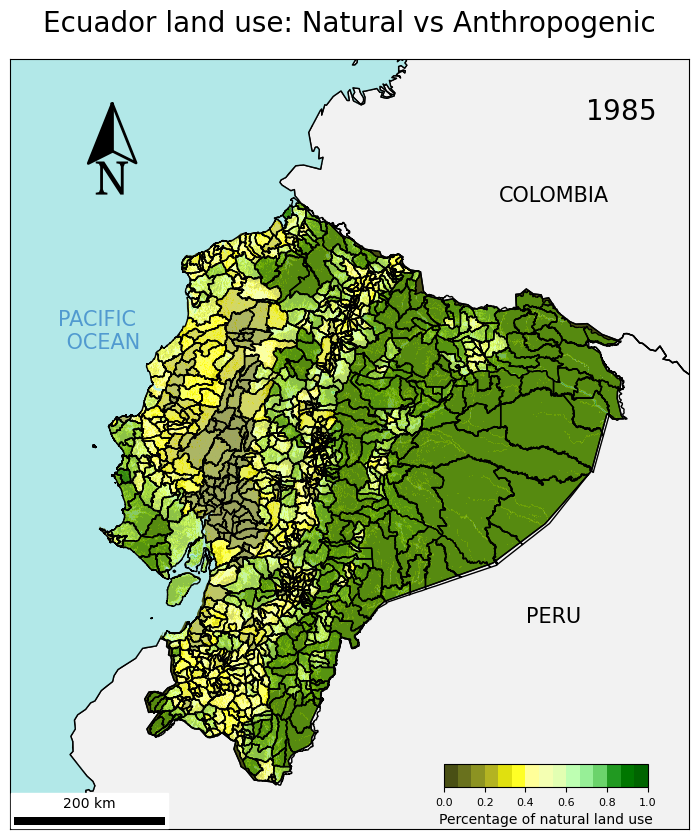

In [22]:
for year in range(1985, 1986):

    df = final_df[final_df['year'] == int(year)]
    preds_year = pd.merge(df, borders[['FEATURE_ID', 'PARROQUIA', 'PROVINCIA', 'CANTON', 'geometry']], on=['PARROQUIA', 'PROVINCIA', 'CANTON'], how='left')
    preds_year = gpd.GeoDataFrame(preds_year, geometry='geometry')

    with rasterio.open(f'../02_data/MB-Ecuador-{year}.tif') as src:

        # Slice the raster data to only include mainland Ecuador
        data = src.read(1)
        sliced_data = data[:, 40000:]
        new_transform = src.window_transform(((0, data.shape[0]), (40000, data.shape[1])))
        raster_crs = src.crs
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot the data with the specified color map
        preds_year.plot(column='zonal_mean', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='black', alpha=0.3)

        # Color scale (color bar) inside the plot at the lower right corner
        cax = inset_axes(ax, width="30%", height="3%", loc="lower right", borderpad=3)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
        cbar.set_label('Percentage of natural land use', fontsize=10, color='black')
        cbar.ax.tick_params(labelsize=8)

        # Load and plot shapefiles (borders, ocean, and neighboring countries as before)
        ecuador_borders = gpd.read_file('../02_data/shapefiles/ecuador_borders.shp')
        ocean_borders = gpd.read_file('../02_data/shapefiles/ne_10m_ocean.shp')

        # Set CRS if needed and reproject to raster CRS as before
        ecuador_borders = ecuador_borders.set_crs("EPSG:4326") if ecuador_borders.crs is None else ecuador_borders
        ecuador_borders = ecuador_borders.to_crs(raster_crs)
        borders = borders.set_crs("EPSG:4326") if borders.crs is None else borders
        borders = borders.to_crs(raster_crs)
        ocean_borders = ocean_borders.set_crs("EPSG:4326") if ocean_borders.crs is None else ocean_borders
        ocean_borders = ocean_borders.to_crs(raster_crs)

        ecuador_borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
        ecuador_borders.plot(ax=ax, color='#f2f2f2', edgecolor='black', linewidth=1)
        borders.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
        ocean_borders.plot(ax=ax, color='#b2e8e8', alpha=1)

        ax.text(-76, -3.15, 'PERU', fontsize=15, color='black', ha='center', va='center')
        ax.text(-76, 1.5, 'COLOMBIA', fontsize=15, color='black', ha='center', va='center')
        ax.text(-81, 0, 'PACIFIC \n OCEAN', fontsize=15, color='#519ad0', ha='center', va='center')

        # Convert lat/lon bounding box to the raster CRS
        transformer = Transformer.from_crs("EPSG:4326", raster_crs)
        xmin, ymin = transformer.transform(-82, -5.5)  # Lower-left corner (lon_min, lat_min)
        xmax, ymax = transformer.transform(-74.5, 3)   # Upper-right corner (lon_max, lat_max)

        # Set the axis limits around Ecuador
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        scalebar = ScaleBar(120, units='km', location='lower left', scale_loc='top', length_fraction=6667 / sliced_data.shape[1])
        ax.add_artist(scalebar)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        add_north_arrow(ax, scale=.75, xlim_pos=.15, ylim_pos=.865, color='#000', text_scaler=4, text_yT=-1.25)

        ax.set_title('Ecuador land use: Natural vs Anthropogenic', color='black', size=20, pad=20.0)
        ax.text(0.95, 0.95, f'${year}$', transform=ax.transAxes, fontsize=20, color='black', ha='right', va='top')

        show(sliced_data, transform=new_transform, ax=ax, cmap=cmap)

        plt.show()    